# Import and Preprocessing

In [2]:
# Import library to work with Kaggle datasets
import opendatasets as od
 
od.download("https://www.kaggle.com/c/dogs-vs-cats/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abdulrashidmukuev
Your Kaggle Key: ········


100%|████████████████████████████████████████| 812M/812M [01:46<00:00, 7.98MB/s]



Extracting archive ./dogs-vs-cats/dogs-vs-cats.zip to ./dogs-vs-cats


In [73]:
# Import all the necessary libraries
import os
import shutil
from zipfile import ZipFile
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.utils import load_img
from keras.utils import img_to_array

plt.rcParams["figure.figsize"] = (20,8)

In [19]:
# Unpacking of train and test data from zip-files
with ZipFile("dogs-vs-cats/train.zip", "r") as zObject:
    zObject.extractall("dogs-vs-cats-raw")

with ZipFile("dogs-vs-cats/test1.zip", "r") as zObject:
    zObject.extractall("dogs-vs-cats-raw")  

In [20]:
# Check some examples
os.listdir("dogs-vs-cats-raw/train")[:10]

['dog.8011.jpg',
 'cat.5077.jpg',
 'dog.7322.jpg',
 'cat.2718.jpg',
 'cat.10151.jpg',
 'cat.3406.jpg',
 'dog.1753.jpg',
 'cat.4369.jpg',
 'cat.7660.jpg',
 'dog.5535.jpg']

* As we can see, pictures are stored in the following format: animal_class.class_example. There are 12500 dogs and cats pictures for the train sample

In [21]:
# Make directories to input data into the keras generator 

# Directory with raw images
original_dataset_dir = 'dogs-vs-cats-raw'

# New directory to store distributed images
base_dir = 'dogs-vs-cats-model'
os.mkdir(base_dir)

# Divide model directory onto train/val/test dirs
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val')
os.mkdir(val_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# For each subdir, make two dirs for cats and dogs

# For train
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# For val
val_cats_dir = os.path.join(val_dir, 'cats')
os.mkdir(val_cats_dir)
val_dogs_dir = os.path.join(val_dir, 'dogs')
os.mkdir(val_dogs_dir)

# For test
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [22]:
# Move all the pictures into created directories

# Define the shape for datasets
train_size = 7500
val_size = 2500
test_size = 2500

# Train Dogs
for i in range(train_size):
    src = os.path.join('dogs-vs-cats-raw/train', f'dog.{i}.jpg')
    dst = os.path.join('dogs-vs-cats-model/train/dogs', f'{i}.jpg')
    shutil.move(src, dst)

# Train Cats
for i in range(train_size):
    src = os.path.join('dogs-vs-cats-raw/train', f'cat.{i}.jpg')
    dst = os.path.join('dogs-vs-cats-model/train/cats', f'{i}.jpg')
    shutil.move(src, dst)

# Val Dogs
for i in range(train_size, train_size + val_size):
    src = os.path.join('dogs-vs-cats-raw/train', f'dog.{i}.jpg')
    dst = os.path.join('dogs-vs-cats-model/val/dogs', f'{i}.jpg')
    shutil.move(src, dst)

# Val Cats
for i in range(train_size, train_size + val_size):
    src = os.path.join('dogs-vs-cats-raw/train', f'cat.{i}.jpg')
    dst = os.path.join('dogs-vs-cats-model/val/cats', f'{i}.jpg')
    shutil.move(src, dst)

# Test Dogs
for i in range(train_size + val_size, train_size + val_size + test_size):
    src = os.path.join('dogs-vs-cats-raw/train', f'dog.{i}.jpg')
    dst = os.path.join('dogs-vs-cats-model/test/dogs', f'{i}.jpg')
    shutil.move(src, dst)

# Test Cats
for i in range(train_size + val_size, train_size + val_size + test_size):
    src = os.path.join('dogs-vs-cats-raw/train', f'cat.{i}.jpg')
    dst = os.path.join('dogs-vs-cats-model/test/cats', f'{i}.jpg')
    shutil.move(src, dst)

In [24]:
# Check
print('Train Cat Images:', len(os.listdir(train_cats_dir)))
print('Train Dog Images:', len(os.listdir(train_dogs_dir)))
print()
print('Val Cat Images:', len(os.listdir(val_cats_dir)))
print('Val Dog Images:', len(os.listdir(val_dogs_dir)))
print()
print('Test Cat Images:', len(os.listdir(test_cats_dir)))
print('Test Dog Images:', len(os.listdir(test_dogs_dir)))

Train Cat Images: 7500
Train Dog Images: 7500

Val Cat Images: 2500
Val Dog Images: 2500

Test Cat Images: 2500
Test Dog Images: 2500


In [25]:
# Check whether all the images open correctly
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("dogs-and-cats-model").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [27]:
# Create generators to catch the images directly from dirs

# Initialization and rescaling images
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

# Defining generators

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

# Val generator
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Modeling and testing

In [30]:
# Simple baseline CNN solution

# Create CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

# Compile CNN
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

# Launch model and return results of learning progress
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 750,
    epochs = 20,
    validation_data = val_generator,
    validation_steps = 250
)

Epoch 1/20


/var/folders/gj/1gr8qsbd1534h56dbj4f_gj00000gn/T/ipykernel_3466/1786826062.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


750/750 [==============================] - 161s 214ms/step - loss: 0.6408 - accuracy: 0.6432 - val_loss: 0.5433 - val_accuracy: 0.7284
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 0.5103 - accuracy: 0.7529 - val_loss: 0.4294 - val_accuracy: 0.8040
Epoch 3/20
750/750 [==============================] - 159s 212ms/step - loss: 0.4185 - accuracy: 0.8144 - val_loss: 0.3900 - val_accuracy: 0.8292
Epoch 4/20
750/750 [==============================] - 159s 212ms/step - loss: 0.3645 - accuracy: 0.8411 - val_loss: 0.4338 - val_accuracy: 0.7990
Epoch 5/20
750/750 [==============================] - 159s 212ms/step - loss: 0.3208 - accuracy: 0.8654 - val_loss: 0.4544 - val_accuracy: 0.8112
Epoch 6/20
750/750 [==============================] - 159s 212ms/step - loss: 0.2859 - accuracy: 0.8854 - val_loss: 0.3731 - val_accuracy: 0.8616
Epoch 7/20
750/750 [==============================] - 159s 212ms/step - loss: 0.2680 - accuracy: 0.8948 - val_loss: 0.3455 - val_accura

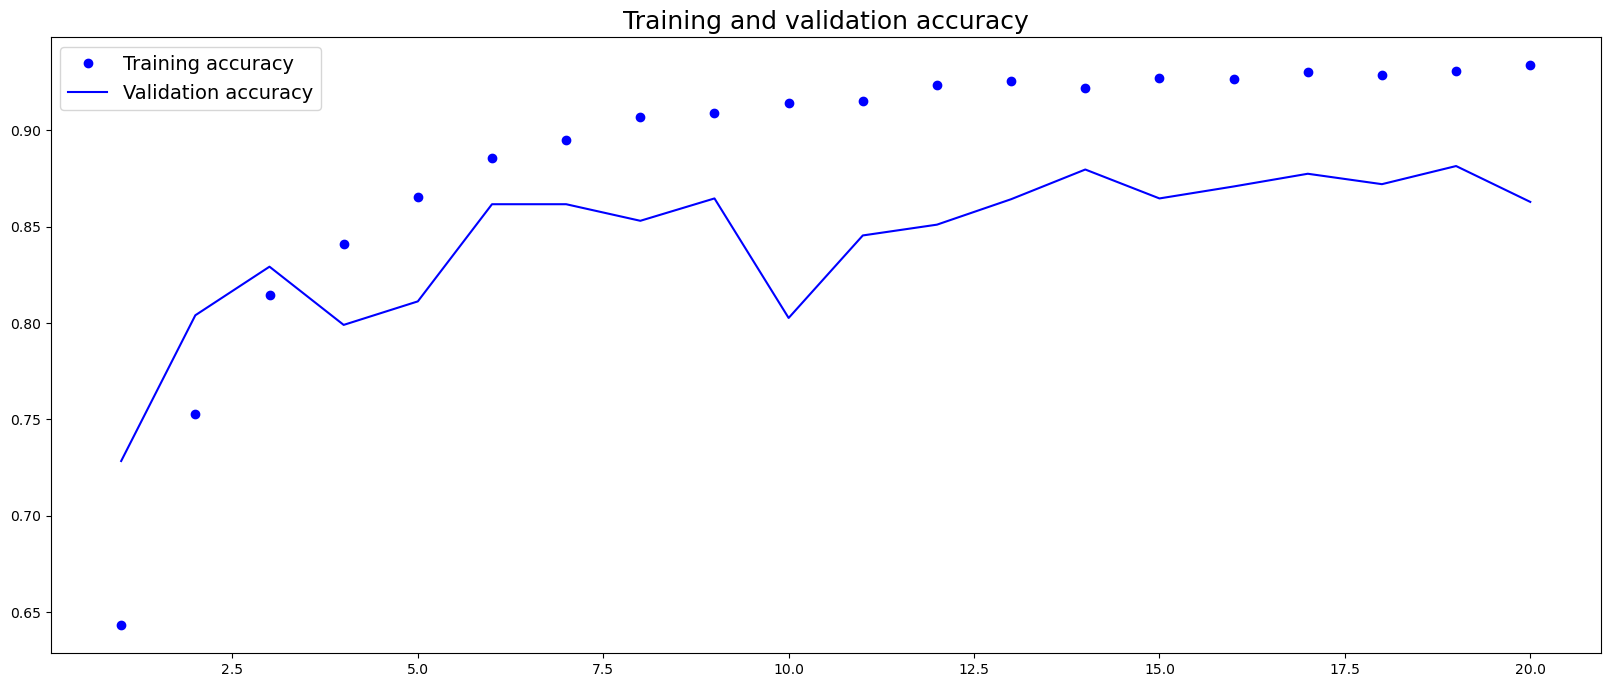

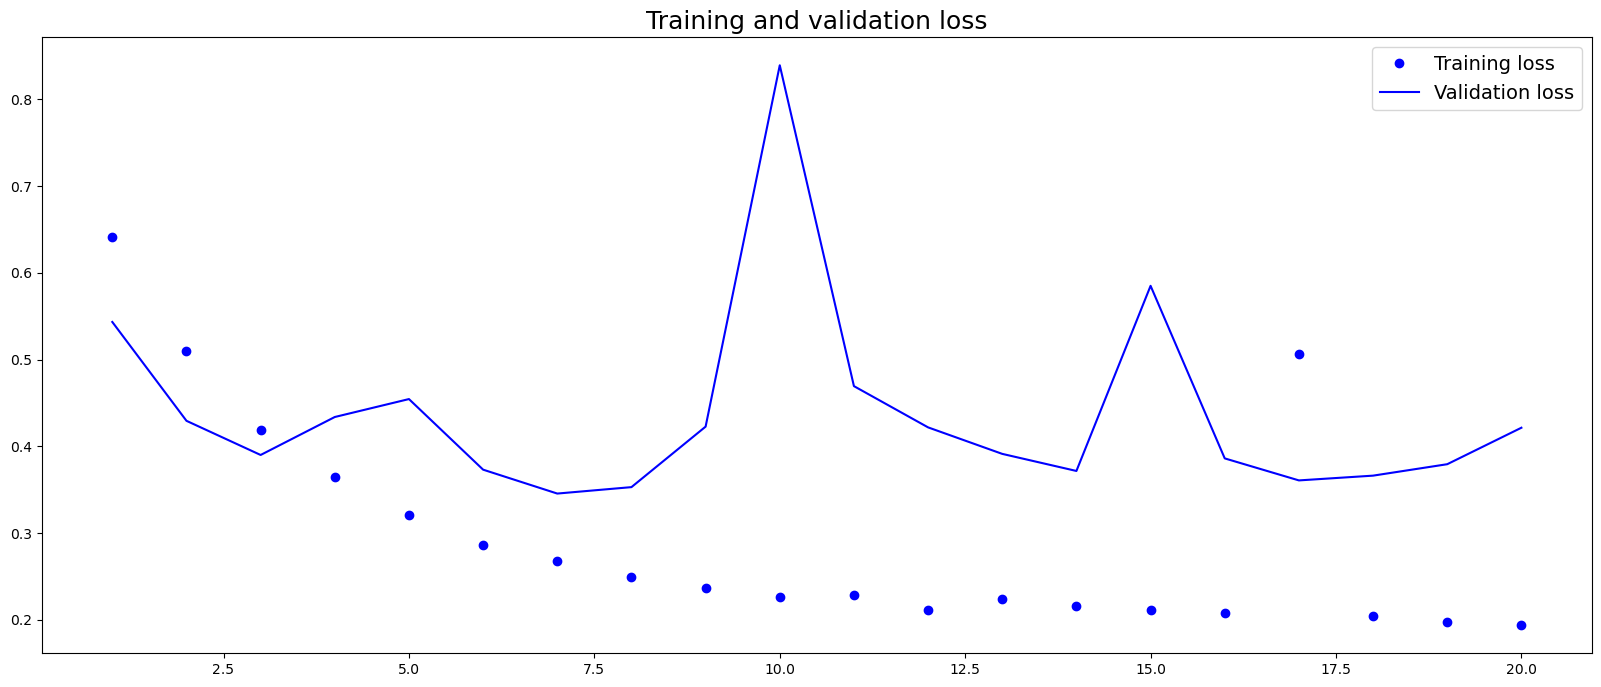

In [31]:
# Visualization of the learning process
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy', fontsize = 18)
plt.legend(fontsize = 14)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss', fontsize = 18)
plt.legend(fontsize = 14)

plt.show()

* There are not significant overfitting according to the graphs. The best accuracy score that we can achieve is about 85-87%. So, we're gonna use an other way to model - use completed convolutional layers, like VGG, transform input images by this layers, and use the outcomes to some dense layers. This way of learning will be pretty fast, so we can spend more time for tuning.

In [33]:
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
conv_base.summary()

58889256/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [35]:
base_dir = 'dogs-vs-cats-model'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch, verbose = 0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_dir, 15000) 
validation_features, validation_labels = extract_features(validation_dir, 5000) 
test_features, test_labels = extract_features(test_dir, 5000)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [36]:
# Change dimensions
train_features = np.reshape(train_features, (15000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (5000, 4 * 4 * 512))
test_features = np.reshape(test_features, (5000, 4 * 4 * 512))

In [37]:
# Learn simple MLP model using CNN outcomes
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

/Users/valtervar/opt/anaconda3/envs/python_study/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/40
750/750 [==============================] - 4s 5ms/step - loss: 0.3819 - acc: 0.8249 - val_loss: 0.2764 - val_acc: 0.8812
Epoch 2/40
750/750 [==============================] - 3s 5ms/step - loss: 0.2726 - acc: 0.8837 - val_loss: 0.2444 - val_acc: 0.9012
Epoch 3/40
750/750 [==============================] - 4s 5ms/step - loss: 0.2416 - acc: 0.8975 - val_loss: 0.2385 - val_acc: 0.8982
Epoch 4/40
750/750 [==============================] - 4s 5ms/step - loss: 0.2248 - acc: 0.9071 - val_loss: 0.2224 - val_acc: 0.9098
Epoch 5/40
750/750 [==============================] - 4s 5ms/step - loss: 0.2125 - acc: 0.9121 - val_loss: 0.2270 - val_acc: 0.9038
Epoch 6/40
750/750 [==============================] - 3s 5ms/step - loss: 0.2040 - acc: 0.9146 - val_loss: 0.2169 - val_acc: 0.9110
Epoch 7/40
750/750 [==============================] - 3s 5ms/step - loss: 0.1952 - acc: 0.9191 - val_loss: 0.2168 - val_acc: 0.9126
Epoch 8/40
750/750 [==============================] - 3s 5ms/step - loss: 0.

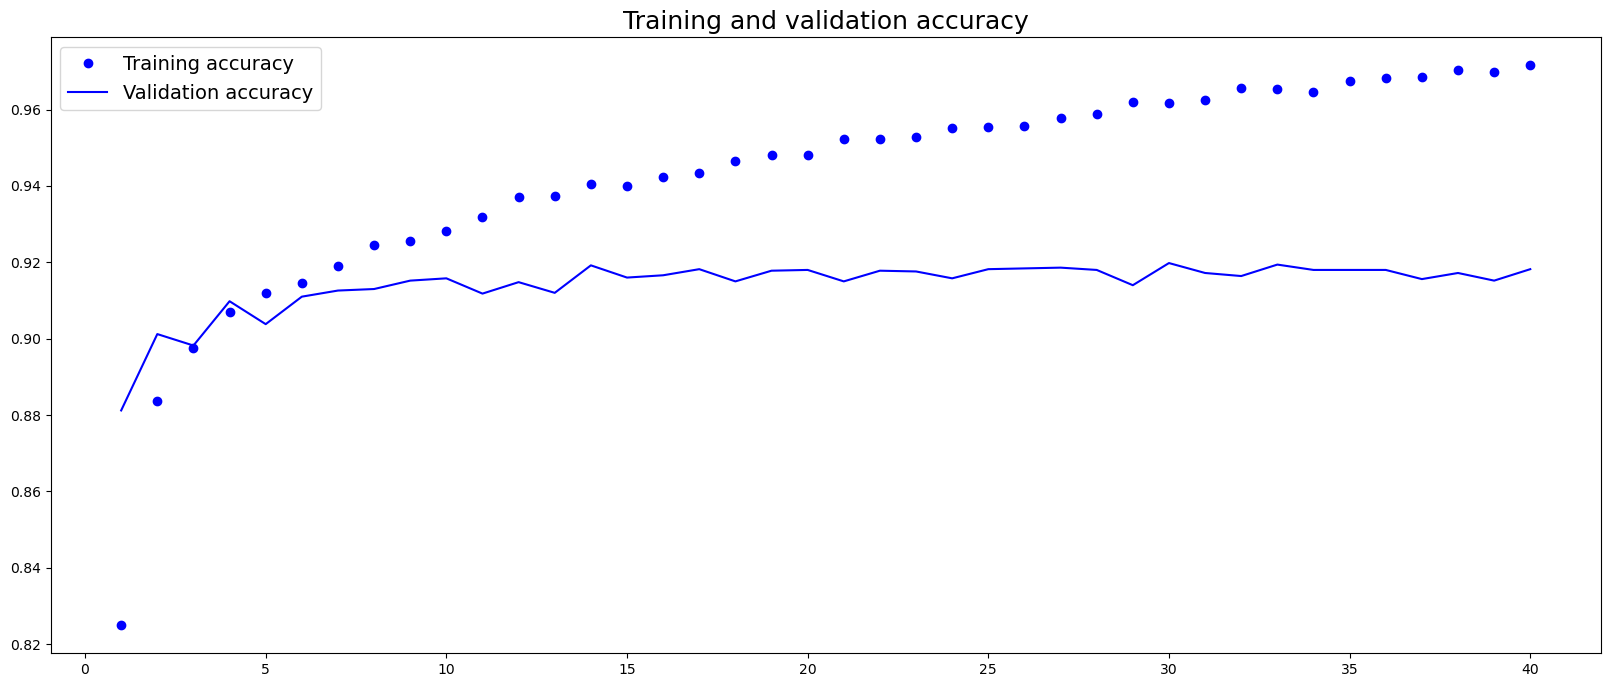

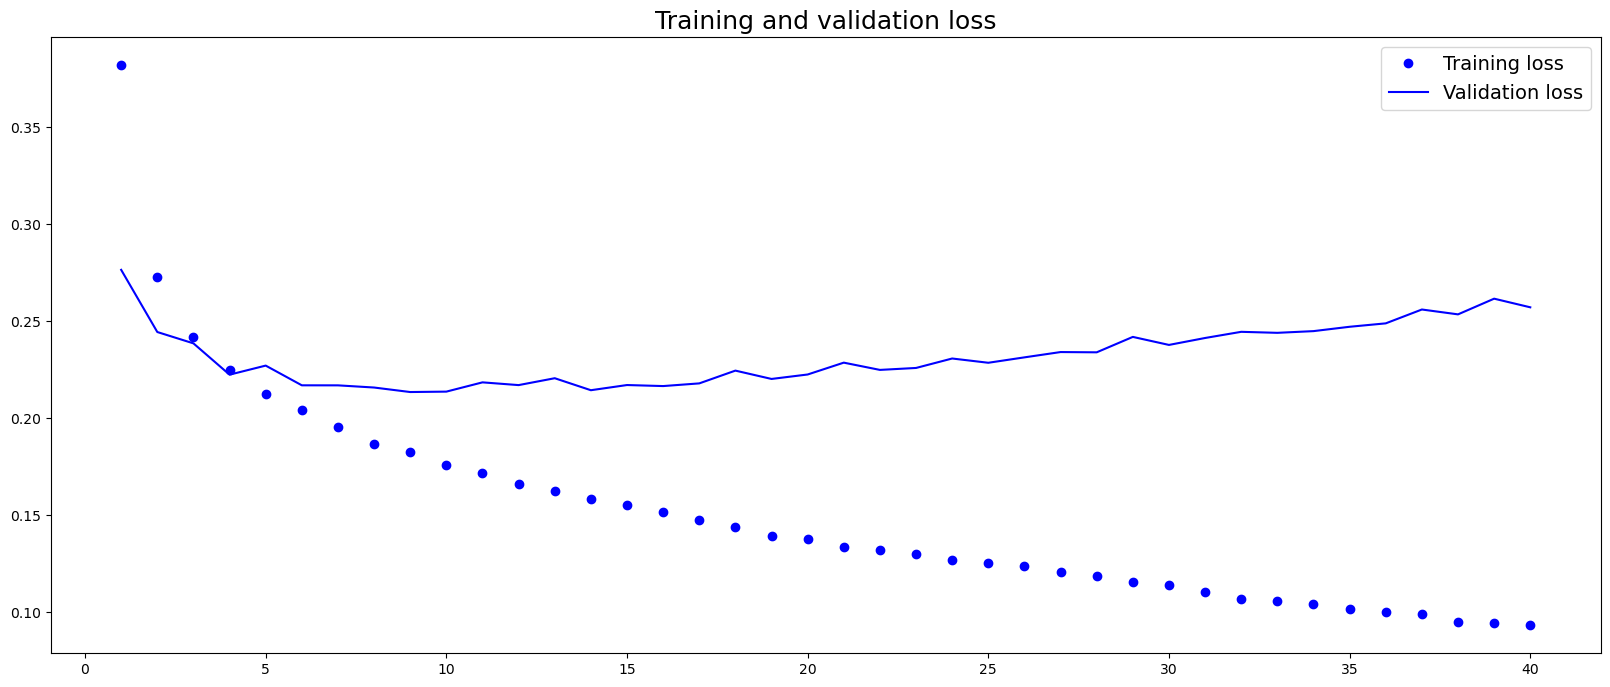

In [39]:
# Visualization of the learning process
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy', fontsize = 18)
plt.legend(fontsize = 14)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss', fontsize = 18)
plt.legend(fontsize = 14)

plt.show()

In [40]:
# Try some additional layers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/40
750/750 [==============================] - 4s 5ms/step - loss: 0.4104 - acc: 0.8095 - val_loss: 0.2758 - val_acc: 0.8828
Epoch 2/40
750/750 [==============================] - 4s 5ms/step - loss: 0.2694 - acc: 0.8860 - val_loss: 0.2407 - val_acc: 0.8996
Epoch 3/40
750/750 [==============================] - 4s 5ms/step - loss: 0.2319 - acc: 0.9046 - val_loss: 0.2349 - val_acc: 0.9022
Epoch 4/40
750/750 [==============================] - 4s 5ms/step - loss: 0.2130 - acc: 0.9111 - val_loss: 0.2409 - val_acc: 0.9038
Epoch 5/40
750/750 [==============================] - 4s 5ms/step - loss: 0.1997 - acc: 0.9164 - val_loss: 0.2430 - val_acc: 0.9014
Epoch 6/40
750/750 [==============================] - 4s 5ms/step - loss: 0.1873 - acc: 0.9252 - val_loss: 0.2197 - val_acc: 0.9138
Epoch 7/40
750/750 [==============================] - 4s 5ms/step - loss: 0.1769 - acc: 0.9284 - val_loss: 0.2193 - val_acc: 0.9150
Epoch 8/40
750/750 [==============================] - 4s 5ms/step - loss: 0.

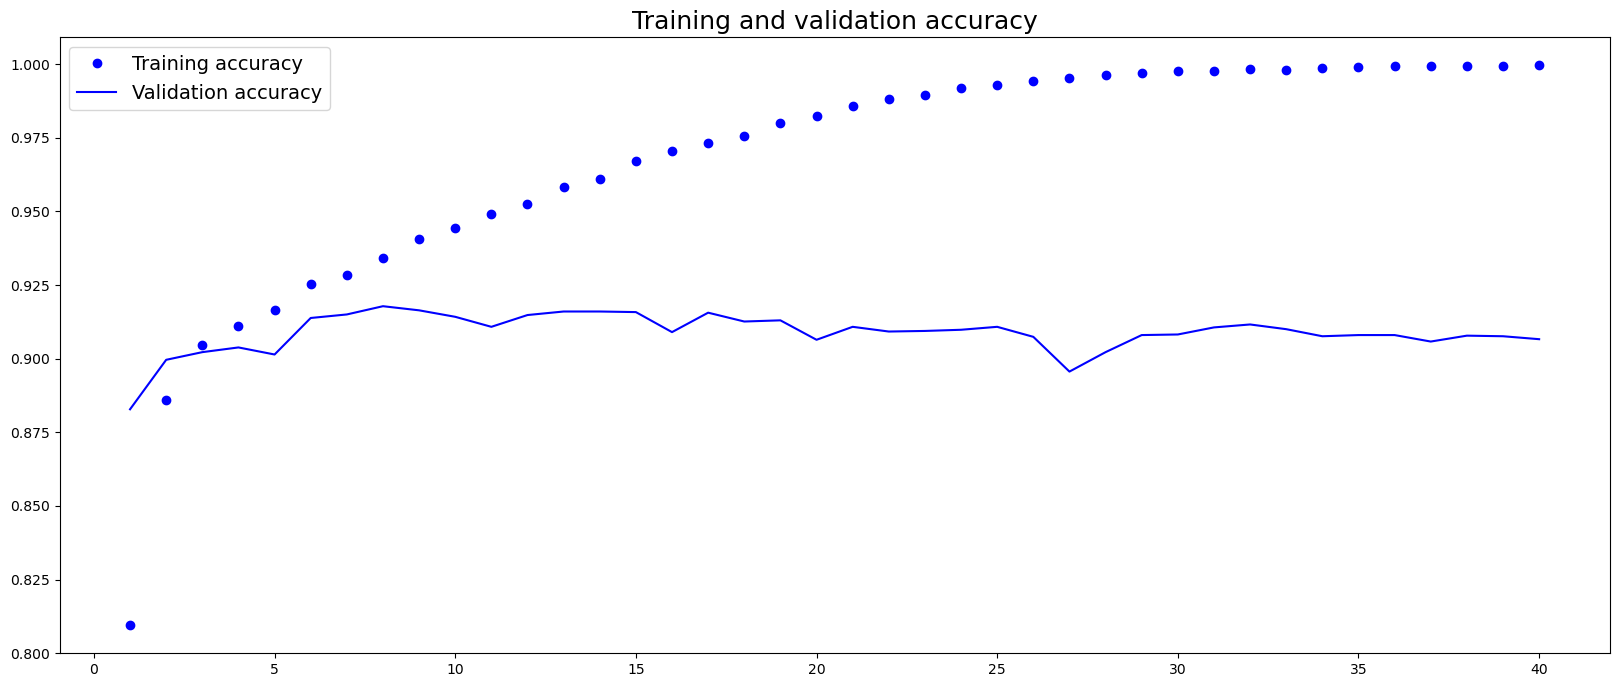

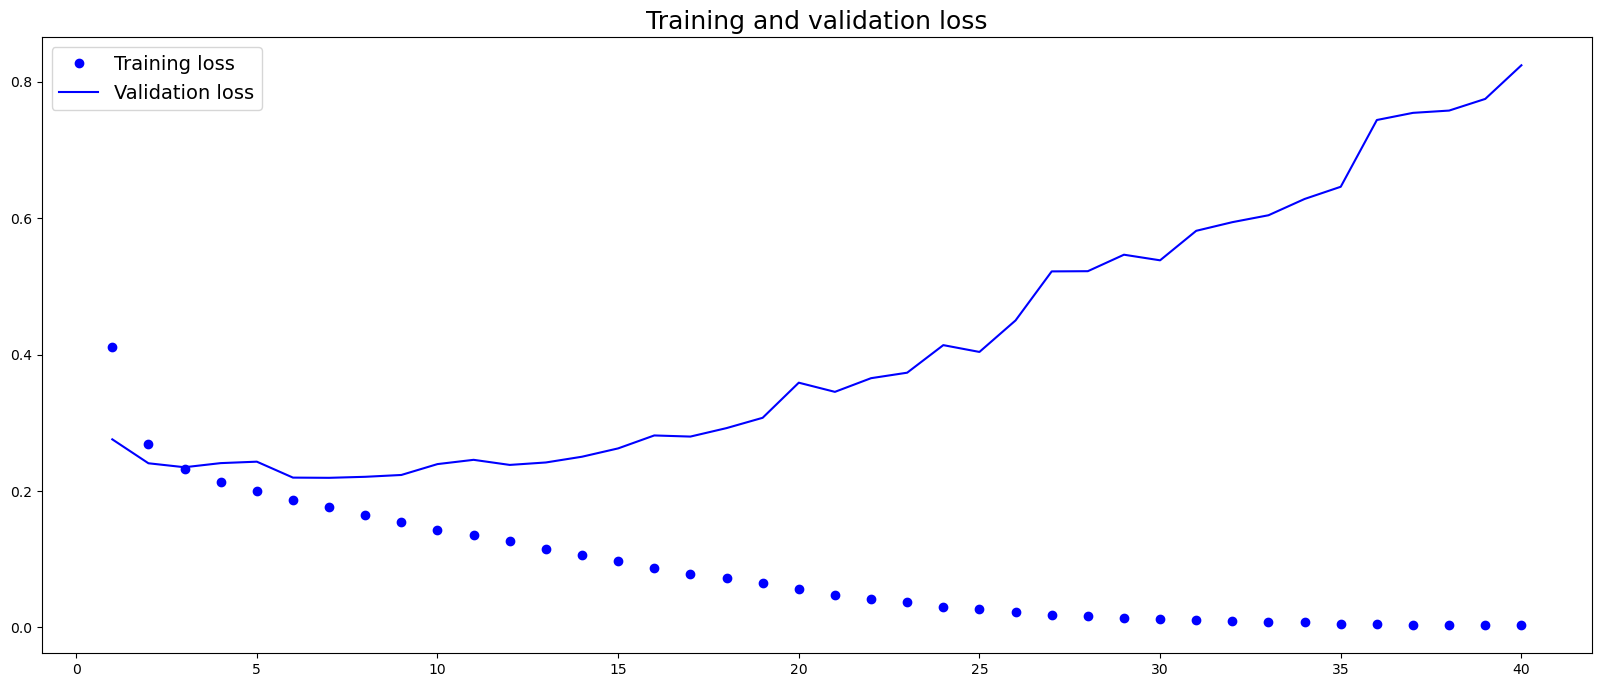

In [41]:
# Visualization of the learning process
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy', fontsize = 18)
plt.legend(fontsize = 14)

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss', fontsize = 18)
plt.legend(fontsize = 14)

plt.show()

* Using 2 additional layers, we properly can see the overfitting. So, we'll use previous version of model and learn it for 15 epochs.

In [42]:
# Final version of model
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(train_features, train_labels,
                    epochs=15,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/15
750/750 [==============================] - 4s 5ms/step - loss: 0.4000 - acc: 0.8157 - val_loss: 0.2741 - val_acc: 0.8814
Epoch 2/15
750/750 [==============================] - 4s 5ms/step - loss: 0.2694 - acc: 0.8877 - val_loss: 0.2379 - val_acc: 0.9016
Epoch 3/15
750/750 [==============================] - 4s 5ms/step - loss: 0.2318 - acc: 0.9048 - val_loss: 0.2289 - val_acc: 0.9046
Epoch 4/15
750/750 [==============================] - 4s 5ms/step - loss: 0.2121 - acc: 0.9127 - val_loss: 0.2233 - val_acc: 0.9100
Epoch 5/15
750/750 [==============================] - 4s 5ms/step - loss: 0.1974 - acc: 0.9200 - val_loss: 0.2218 - val_acc: 0.9078
Epoch 6/15
750/750 [==============================] - 4s 5ms/step - loss: 0.1851 - acc: 0.9262 - val_loss: 0.2202 - val_acc: 0.9144
Epoch 7/15
750/750 [==============================] - 4s 5ms/step - loss: 0.1724 - acc: 0.9320 - val_loss: 0.2251 - val_acc: 0.9134
Epoch 8/15
750/750 [==============================] - 4s 5ms/step - loss: 0.

In [43]:
# Final evaluation on test part of the train data
model.evaluate(test_features, test_labels)

157/157 [==============================] - 0s 2ms/step - loss: 0.2774 - acc: 0.9082


[0.27737611532211304, 0.9082000255584717]

# Preparing the file-result

In [62]:
# Check the size of test data
len(os.listdir('dogs-vs-cats-raw/test1'))

12500

In [64]:
# Making a new directory for the test data
size = 12500

original_dataset_dir = 'dogs-vs-cats-raw'
base_dir = 'dogs-vs-cats-model'
final_dir = os.path.join(base_dir, 'final')
os.mkdir(final_dir)

for i in range(1, size + 1):
    src = os.path.join('dogs-vs-cats-raw/test1', f'{i}.jpg')
    dst = os.path.join('dogs-vs-cats-model/final', f'{i}.jpg')
    shutil.move(src, dst)

In [82]:
# Transformation of test images via VGG16
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

features = np.zeros(shape = (size, 4, 4, 512))
labels = np.zeros(shape = (size))

generator = datagen.flow_from_directory(
    final_dir,
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode='binary',
    shuffle = False,
    classes = ['.']
    )

i = 0
for inputs_batch, labels_batch in tqdm(generator):
    features_batch = conv_base.predict(inputs_batch, verbose = 0)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= size:
        break

Found 12500 images belonging to 1 classes.


100%|████████████████████████████████████████▉| 624/625 [13:40<00:01,  1.31s/it]


In [83]:
# Change dimensions
features = np.reshape(features, (12500, 4 * 4 * 512))

In [101]:
# Predict probabilities
predictions = model.predict(features)

391/391 [==============================] - 1s 2ms/step


In [103]:
# Convert probabilities into answers
predictions = np.where(predictions >= 0.5, 1, 0)

In [110]:
# Creating a dataframe
result = pd.DataFrame(predictions, columns = ['label'])
result['label'] = result['label'].astype('string')
result['id'] = range(1, 12501)
result.set_index('id', drop = True, inplace = True)
result

,label
id,
1,1
2,0
3,0
4,1
5,1
...,...
12496,0
12497,1
12498,1


In [111]:
result.to_csv('result.csv')